In [2]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np
import sklearn

In [3]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci


#### small demo of CI lib

In [ ]:
y_true = [0, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1]
y_pred = [0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1]
# You can specify a random generator for reproducability, or pass None
random_generator = np.random.default_rng()
bootstrap_ci(y_true=y_true,
             y_pred=y_pred,
             metric=sklearn.metrics.accuracy_score, # change to any metrics
             metric_average='n.a.', # if multi-class you can specify the average method, i.e. ‘micro’, ‘macro’, ‘samples’, ‘weighted’
             confidence_level=0.95,
             n_resamples=9999,
             method='bootstrap_bca',
             random_state=random_generator)

In [ ]:
classification_report_with_ci(y_true, y_pred)

# Evaluate Multi-Class


## Load file with predictions

In [4]:
prompt_ids_to_eval = ["P7"] #["P1", "P4_1", "P5"] # ["P6", "P7", "P11_3", "P11_4"]
model = "gpt-3.5-turbo" #"gpt-4-turbo-preview"

In [5]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

In [6]:
#gpt-4-turbo-preview_enriched_kw_test_outputs_P6_P7_P11_3_P11_4.csv 
df = pd.read_csv(f"predictions/{model}_enriched_kw_test_outputs_{'_'.join(prompt_ids_to_eval)}.csv")[columns_to_read]


In [7]:
df.shape

(534, 5)

In [8]:
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P7
0,12047012,Non-systematic-review,1,0,Non-systematic-review
1,28832188,Non-systematic-review,1,0,Human-systematic-review
2,17678496,Non-systematic-review,1,0,Clinical-study-protocol
3,25649308,Non-systematic-review,1,0,Human-systematic-review
4,6312596,Non-systematic-review,1,0,Human-systematic-review


## Map predictions to numerical

In [9]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [10]:
numerical_to_label = {v: f"{k}" for k, v in label_to_numerical.items()}
numerical_to_label

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [11]:
import difflib
def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [12]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [13]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        print(label)
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        # If fuzzy match did not work, check if the label string contains the key 'label' and use it to split the string; keep everything to the right as the potential label
        if numerical_label == -1:
            if 'label' in label:
                label_part = label.split('label')[1]
                numerical_label = map_label_fuzzy(label_part, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P7,accepted_label_numerical,gpt_predictions_P7_numerical
0,12047012,Non-systematic-review,1,0,Non-systematic-review,1,1
1,28832188,Non-systematic-review,1,0,Human-systematic-review,1,7
2,17678496,Non-systematic-review,1,0,Clinical-study-protocol,1,12
3,25649308,Non-systematic-review,1,0,Human-systematic-review,1,7
4,6312596,Non-systematic-review,1,0,Human-systematic-review,1,7


In [14]:
df.to_csv(f"predictions/{model}_enriched_kw_test_test_outputs_{'_'.join(prompt_ids_to_eval)}_structured.csv")

In [15]:
df[df['pmid'] == 19812460]

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P7,accepted_label_numerical,gpt_predictions_P7_numerical
86,19812460,Human-RCT-non-drug-intervention,9,0,Human-RCT-non-drug-intervention,9,9


#### Important: some labels from GPT could not be mapped to a target label

In [16]:
rows_with_minus_one = df[(df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P7,accepted_label_numerical,gpt_predictions_P7_numerical


## Evaluate prompts

In [17]:
def evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, digits=3):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits = digits)

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report)
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        report_df.set_index('class', inplace=True)
        summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}_with_ci.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_enriched_kw_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv")
    summary_df.to_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


Evaluating  P7


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Results saved to evaluations/ and plots/ folders.


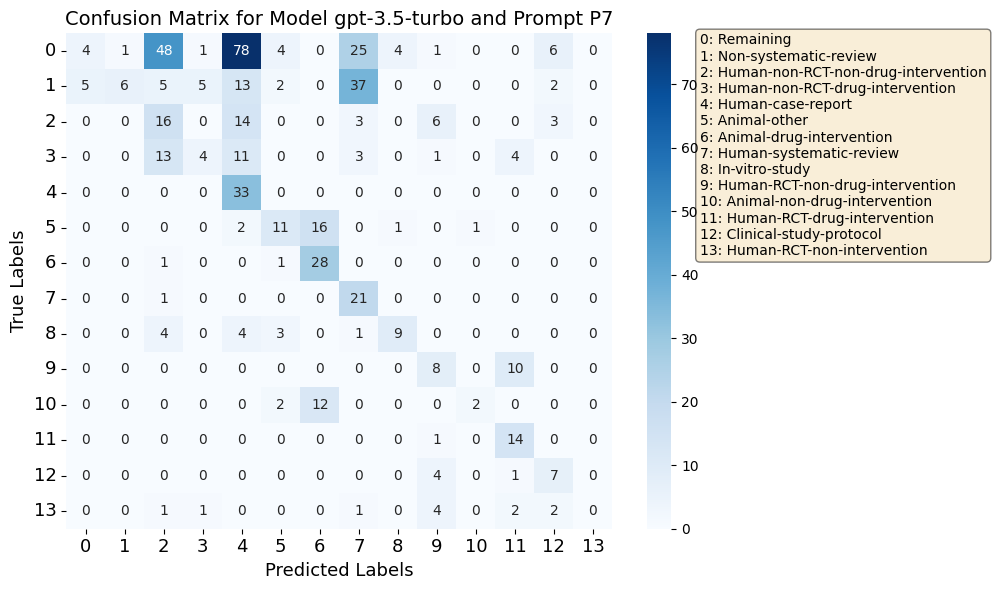

In [18]:
target_label_col = 'accepted_label_numerical'
eval_type = 'multi_label'
all_reports_df, summary_df = evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, digits=3)


In [ ]:
summary_df

In [ ]:
all_reports_df

## Format Results and Generate LateX

In [ ]:
model = "gpt-4-turbo-preview"

prompt_ids_to_eval = ["P6", "P7", "P11_3", "P11_4"]
summary_gpt4_raw_1 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1", "P4_1", "P5"]
summary_gpt4_raw_2 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt4_raw = pd.concat([summary_gpt4_raw_1,summary_gpt4_raw_2]) 
summary_gpt4_raw

In [ ]:
model = "gpt-3.5-turbo"

prompt_ids_to_eval = ["P5"]
summary_gpt3_raw_1 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P6"]
summary_gpt3_raw_2 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1"]
summary_gpt3_raw_3 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P7"]
summary_gpt3_raw_4 = pd.read_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt3_raw = pd.concat([summary_gpt3_raw_1,summary_gpt3_raw_2, summary_gpt3_raw_3, summary_gpt3_raw_4]) 
summary_gpt3_raw

In [ ]:
map_prompt_to_concept = {
    'P1': 'zero-shot',
    'P4_1': 'CC',
    'P5': 'CC',
    'P6': 'CC',
    'P7': 'CoT',
    'P11_3': 'CoT + CC',
    'P11_4': 'CoT + CC'
}

In [ ]:
# Custom sorting function
def custom_sort(prompt):
    import re
    # Extract numbers from the prompt
    numbers = re.findall(r'\d+', prompt)
    if numbers:
        # Primary sort by the first number, secondary sort by the full string
        return (int(numbers[0]), prompt)
    return (float('inf'), prompt)  # Handles cases without numbers
    
def format_summary_for_latex_report(summary_df, map_prompt_to_concept):
    summary_df = summary_df.copy()
    
    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision CI'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall CI'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score CI'].astype(str)
    summary_df['Accuracy (CI)'] = summary_df['accuracy'].astype(str) + ' ' + summary_df['accuracy CI'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI'], inplace=True)
    
    # Rename 'Prompt ID' to 'Prompt'
    summary_df.rename(columns={'Prompt ID': 'Prompt'}, inplace=True)
    
    # Apply the mapping
    summary_df['Concept'] = summary_df['Prompt'].map(map_prompt_to_concept)
    
    # Rearrange the columns to put 'Concept' after 'Prompt'
    summary_df = summary_df[['Prompt', 'Concept', 'Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)']]

    summary_df['sort_key'] = summary_df['Prompt'].apply(custom_sort)
    summary_df.sort_values('sort_key', inplace=True)
    summary_df.drop('sort_key', inplace=True, axis=1)
    
    return summary_df
    

In [ ]:
summary_gpt4 = format_summary_for_latex_report(summary_gpt4_raw, map_prompt_to_concept)
summary_gpt4['Model'] = 'gpt-4'
summary_gpt4

In [ ]:
print(summary_gpt4.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

In [ ]:
summary_gpt3 = format_summary_for_latex_report(summary_gpt3_raw, map_prompt_to_concept)
summary_gpt3['Model'] = 'gpt-3.5'
summary_gpt3

In [ ]:
print(summary_gpt3.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

In [ ]:
# Combine the DataFrames
combined_df = pd.concat([summary_gpt4, summary_gpt3])

# Pivot table with multi-level columns for metrics and models as subcolumns
pivot_df = combined_df.pivot_table(
    index=['Prompt', 'Concept'],
    columns='Model',
    values=['Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)'],
    aggfunc='first'
)

# Simplify the MultiIndex in columns
pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.reset_index()

pivot_df['sort_key'] = pivot_df['Prompt'].apply(custom_sort)
pivot_df.sort_values('sort_key', inplace=True)
pivot_df.drop('sort_key', inplace=True, axis=1)

pivot_df

In [ ]:
print(pivot_df.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

### archive for reference

In [ ]:
def evaluate_predictions(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(label_to_numerical)), target_names=[numerical_to_label[i] for i in range(len(label_to_numerical))])

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report).transpose()
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        summary = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_enriched_kw_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    summary_df.to_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #all_reports_df.to_csv(f"evaluations/{model}_enriched_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #summary_df.to_csv(f"evaluations/{model}_enriched_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df
